In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
import os
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd

import PIL
from PIL import Image
import openslide

from wsi.slide import downsample
from wsi.slide import thumbnail
from wsi.patch import save_slide_patches, get_slide_patches_params

from IPython.display import display 

In [3]:
with open('conf/user_conf.yaml', 'r') as f:
    conf = yaml.load(f)

**Config**

In [4]:
MAGNIFICATION = 2.5
PATCH_SIZE = 128

THUMBNAIL_SIZE = 1024
DISPLAY_SIZE = (400, 400)

In [5]:
slides_path = os.path.join(conf['data_path'], 'slides', 'svs')

In [6]:
patches_path = os.path.join(conf['data_path'], 'slides', 'patches')

if not os.path.exists(patches_path):
    os.mkdir(patches_path)

In [7]:
thumbnails_path = os.path.join(conf['data_path'], 'slides', 'thumbnail')

if not os.path.exists(thumbnails_path):
    os.mkdir(thumbnails_path)

In [8]:
slides_df = pd.read_csv(os.path.join(conf['data_path'], 'slides_metadata.csv'), sep='|')
slides_df = slides_df[slides_df['file_name'].isin(os.listdir(slides_path))]

In [9]:
slides_df.head(2)

,file_id,case_id,sample_id,slide_id,data_type,experimental_strategy,data_format,file_size,file_name,primary_site,disease_type,sample_type,is_ffpe,percent_normal_cells,percent_stromal_cells,percent_tumor_cells,percent_tumor_nuclei
1,7ec5c9d0-8c22-4e30-bae8-605c3dcfe744,TCGA-HZ-A49I,TCGA-HZ-A49I-01A,TCGA-HZ-A49I-01A-01-TS1,Slide Image,Tissue Slide,SVS,293.72,TCGA-HZ-A49I-01A-01-TS1.svs,Pancreas,Ductal and Lobular Neoplasms,Primary Tumor,False,40.0,55.0,5.0,5.0
2,265adb6b-913e-490c-8cea-32d67c1440a2,TCGA-3A-A9IZ,TCGA-3A-A9IZ-01A,TCGA-3A-A9IZ-01A-01-TS1,Slide Image,Tissue Slide,SVS,166.95,TCGA-3A-A9IZ-01A-01-TS1.svs,Pancreas,Ductal and Lobular Neoplasms,Primary Tumor,False,25.0,0.0,65.0,40.0


## Save slide thumbnails

In [95]:
for file in tqdm(slides_df['file_name'].values, unit='file'):
    
    os_img = openslide.open_slide(os.path.join(slides_path, file))
    img = thumbnail(os_img, max_size=THUMBNAIL_SIZE)
    
    img.save(os.path.join(thumbnails_path, file.replace('.svs', '.png')))

## Patching

In [10]:
files = os.listdir(slides_path)
file= files[89]
file

'TCGA-IB-A5ST-01A-01-TSA.svs'

In [11]:
file = [x for x in files if '6880' in x][1]

In [12]:
os_img = openslide.open_slide(os.path.join(slides_path, file))

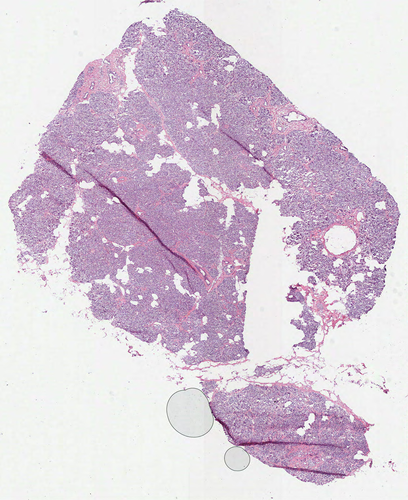

In [13]:
thumbnail(os_img, max_size=500)

In [14]:
os_img.level_downsamples

(1.0, 4.000131908719166, 16.001583113456462)

In [15]:
os_img.level_dimensions

((24752, 30326), (6188, 7581), (1547, 1895))

In [16]:
levels_magnification = [int(os_img.properties['aperio.AppMag'])/int(x) for x in os_img.level_downsamples]
levels_magnification

[40.0, 10.0, 2.5]

In [17]:
patches_params = get_slide_patches_params(os_img, PATCH_SIZE, MAGNIFICATION)

In [18]:
len(patches_params)

180

In [140]:
save_slide_patches(os.path.join(slides_path, file), patches_path, 
                   patch_size=PATCH_SIZE, magnification=MAGNIFICATION)

True

In [19]:
patches_params = get_slide_patches_params(os_img, PATCH_SIZE, MAGNIFICATION)

In [67]:
import random

In [68]:
patch_params  = random.choice(patches_params)
patch_params

{'index': (0, 5),
 'location': [10241, 16],
 'level': 2,
 'level_patch_size': (128, 128),
 'patch_size': (128, 128),
 'resize': 1.0}

In [78]:
patch_img = os_img.read_region(patch_params['location'], patch_params['level'], patch_params['level_patch_size'])

In [79]:
patch_arr = np.asarray(patch_img.convert('RGB'))

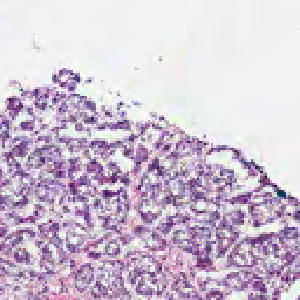

In [80]:
display_img_array(patch_arr)

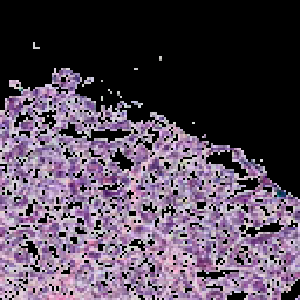

In [81]:
patch_arr = filter_whites(patch_arr)
display_img_array(patch_arr)

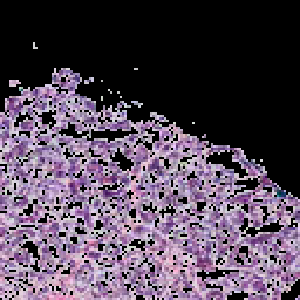

In [82]:
patch_arr_filt = filter_grays(patch_arr, tolerance=100, reverse=False)
display_img_array(patch_arr_filt)

In [93]:
np.unique(mask.sum(axis=2))

array([0, 2, 3])

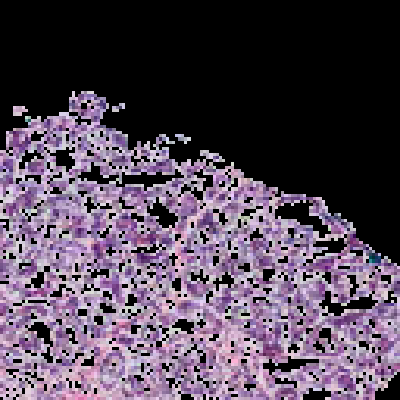

In [87]:
mask = remove_small_objects(patch_arr_filt.astype(bool), min_size=20, connectivity=1)
patch_arr_filt = patch_arr_filt * mask

Image.fromarray(patch_arr_filt * new_image).resize(DISPLAY_SIZE)

In [103]:
total_pixels

49152

In [101]:
total_pixels = patch_arr_filt.size

51.13

In [106]:
from skimage.morphology import remove_small_objects

def rgb_to_gray(rgb):
    gray = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    return gray

def filter_whites(rgb, maximum=220, filter_color=[0,0,0]):
    
    gray = rgb_to_gray(rgb)
    mask = gray > maximum
    
    rgb.setflags(write=1)
    rgb[mask,:] = filter_color
    rgb.setflags(write=0)
    
    return rgb

def filter_greys(rgb, tolerance=15, reverse=False):
    """
    Create a mask to filter out pixels where the red, green, and blue channel values are similar.

    Args:
    tolerance: Tolerance value to determine how similar the values must be in order to be filtered out
    """
    
    rg_diff = abs(rgb[:, :, 0] - rgb[:, :, 1]) <= tolerance
    rb_diff = abs(rgb[:, :, 0] - rgb[:, :, 2]) <= tolerance
    gb_diff = abs(rgb[:, :, 1] - rgb[:, :, 2]) <= tolerance
    
    mask = ~(rg_diff & rb_diff & gb_diff)
    mask = ~mask if reverse else mask
        
    rgb = rgb * np.dstack([mask, mask, mask])
       
    return rgb

def display_img_array(img_array, size=(300, 300)):
    return Image.fromarray(img_array).resize(size)

def get_zero_pixel_percetange(img):
    
    zero_pixels = (img == 0).sum()
    percetange_zero = round(100 * zero_pixels / total_pixels, 2)
    
    return percetange_zero
    

SyntaxError: unexpected EOF while parsing (<ipython-input-106-4c0809ef961e>, line 42)

In [107]:
np

<module 'numpy' from '/Users/portizdegalisteo/anaconda3/lib/python3.7/site-packages/numpy/__init__.py'>

For all slides

In [133]:
for file in tqdm(files): 
    
    os_img = openslide.open_slide(os.path.join(slides_path, file))

    save_slide_patches(os.path.join(slides_path, file), patches_path, file_prefix=file.replace('.svs', ''), 
                       patch_size=PATCH_SIZE, magnification=MAGNIFICATION)

TypeError: save_slide_patches() got an unexpected keyword argument 'file_prefix'

## Single slide test

In [ ]:
file = big_slide

**Read**

In [ ]:
os_img = openslide.open_slide(os.path.join(slides_path, file))

**Reduce dimensions**

In [ ]:
img_arr = downsample(os_img, DOWNSAMPLING)

In [ ]:
img = PIL.Image.fromarray(img_arr)

## Functions

In [ ]:
input_paths = 

## Tests

In [ ]:
from wsi.slide import open_slide, show_slide
import openslide
from tqdm import tqdm_notebook as tqdm

In [ ]:
slides_info = []

In [ ]:
for slide_file in tqdm(os.listdir(slides_path)):
    
    if slide_file == 'Icon\r':
        continue
        
    slide_img = openslide.open_slide(os.path.join(slides_path, slide_file))
    
    slide_info = {'file': slide_file}
    
    slide_info['magnification'] = slide_img.properties['aperio.AppMag']
    slide_info['n_levels'] = slide_img.level_count
    w,h = slide_img.dimensions
    slide_info['height'] = h
    slide_info['width'] = w
    
    for i,dim in enumerate(slide_img.level_dimensions):
        w,h = dim
        slide_info['height_' + str(i)] = h
        slide_info['width_' + str(i)] = w
        
    slides_info.append(slide_info)

In [ ]:
slide_info = pd.DataFrame(slides_info)

In [ ]:
slide_info

In [ ]:
slide_info.groupby(['n_levels', 'magnification']).size()

In [ ]:
sli

In [ ]:
slide_img.level_dimensions

In [ ]:
im = open_slide(image)

In [ ]:
size = [int(x/1024) for x in slide.dimensions]

In [ ]:
size

In [ ]:
slide_down = slide.read_region((0,0), 3, size)

In [ ]:
slide_down

In [ ]:
show_slide(image)

In [ ]:
slides_path

In [ ]:
image

In [ ]:
slide = openslide.open_slide(os.path.join(slides_path, image))

In [ ]:
slide

In [ ]:
slide.dimensions

In [ ]:
slide.level_count

In [ ]:
slide.level_dimensions

In [ ]:
slide.dimensions

In [ ]:
slide.get_thumbnail((1000,1000))

In [ ]:
slide.properties['aperio.AppMag']

In [ ]:
slide.dimensions

In [ ]:
dims = []
mags = []
lvl = []
dow = []

for file in os.listdir(slides_path):
    if file == 'Icon\r':
        continue
    try:
        slide = openslide.open_slide(os.path.join(slides_path, file))
        dims.append(slide.dimensions)
        mags.append(slide.properties['aperio.AppMag'])
        lvl.append(slide.properties['openslide.level-count'])
        dow.append(int(float(slide.properties['openslide.level[1].downsample'])))
    except Exception as e:
        os.remove(os.path.join(slides_path, file))

In [ ]:
set(dow)

In [ ]:
lvl

In [ ]:
lvl_20 = [x for x,y in zip(lvl,mags) if y == '20']
lvl_40 = [x for x,y in zip(lvl,mags) if y == '40']

In [ ]:
lvl_20

In [ ]:
lvl_40

In [ ]:
mags.index('20')

In [ ]:
dims_20 = [x for x,y in zip(dims,mags) if y == '20']
dims_40 = [x for x,y in zip(dims,mags) if y == '40']

In [ ]:
import numpy as np

In [ ]:
dims_20 = np.array(dims_20)

In [ ]:
dims_20[:,0].mean()

In [ ]:
dims_20[:,1].mean()

In [ ]:
dims_40 = np.array(dims_40)

In [ ]:
dims_40[:,0].mean()

In [ ]:
dims_40[:,1].mean()

In [ ]:
slide.properties['openslide.objective-power']

In [ ]:
slide.properties

In [ ]:
dims

**slide_to_scaled_image**

In [ ]:
DOWNSAMPLE = 64

In [ ]:
slide_name = 'TCGA-HV-A5A6-01A-01-TS1.svs'

In [ ]:
slide = openslide.open_slide(os.path.join(slides_path, slide_name))

In [ ]:
slide

In [ ]:
width, height = slide.dimensions

In [ ]:
width

In [ ]:
height

In [ ]:
new_width = int(width / DOWNSAMPLE)
new_height = int(height / DOWNSAMPLE)

In [ ]:
new_width

In [ ]:
new_height

In [ ]:
best_level = slide.get_best_level_for_downsample(16)

In [ ]:
best_level

In [ ]:
slide_down = slide.read_region((0,0), best_level, slide.level_dimensions[best_level])

In [ ]:
slide_down

In [ ]:
slide_down = slide_down.convert('RGB')

In [ ]:
slide_img = slide_down.resize((new_width, new_height), PIL.Image.BILINEAR)

In [ ]:
slide_img

In [ ]:
slide_img.save('test.png')

In [ ]:
slide_down.mode

In [ ]:
from wsi.util import display_img, pil_to_np_rgb, np_to_pil
from wsi import filter

In [ ]:
np_img = pil_to_np_rgb(slide_img)

In [ ]:
slide_grey = slide_img.convert('L')

In [ ]:
np_grey = filter.filter_rgb_to_grayscale(np_img)

In [ ]:
np_to_pil(np_grey)

In [ ]:
np_comp = filter.filter_complement(np_img)

In [ ]:
np_to_pil(np_comp)

In [ ]:
np_comp

In [ ]:
np_img.mean()

In [ ]:
np_to_pil(np_img)

In [ ]:
contrast_stretch = filter.filter_contrast_stretch(np_comp, low=100, high=200)

In [ ]:
np_to_pil(contrast_stretch)

In [ ]:
np_to_pil(np_comp)

In [ ]:
contrast_stretch_com = filter.filter_complement(contrast_stretch)

In [ ]:
np_to_pil(contrast_stretch_com)

In [ ]:
np_to_pil(np_grey)

In [ ]:
np_to_pil(filter.filter_histogram_equalization(np_grey))

In [ ]:
hed = filter.filter_rgb_to_hed(np_img)

In [ ]:
hema = filter.filter_hed_to_hematoxylin(hed)

In [ ]:
hema = filter.filter_hed_to_hematoxylin(hed)
display_img(hema, "Hematoxylin Channel")
eosin = filter.filter_hed_to_eosin(hed)
display_img(eosin, "Eosin Channel")

In [ ]:
np_to_pil(np_img)

In [ ]:
r = np_img[:,:,0] < 80
g = np_img[:,:,1] < 80
a = np_img[:,:,2] < 80

In [ ]:
np_img.shape

In [ ]:
r.shape

In [ ]:
np_img

In [ ]:
res = ~(r & g & a)

In [ ]:
res = res.astype(float)

In [ ]:
res

In [ ]:
np_img.setflags(write=1)

In [ ]:
res.shape

In [ ]:
np_to_pil(np_img)

In [ ]:
res = np.dstack([res, res, res])

In [ ]:
np_to_pil(-res * np_img)

In [ ]:
res = np.dstack([res, res, res])

**PY-WSI (YBECCA)**

In [ ]:
turtle = py_wsi.Turtle(slides_path, db_path, 'test', storage_type='disk')

In [ ]:
patch_1 = turtle.retrieve_sample_patch("TCGA-HZ-8001-01A-01-TS1.svs", 256, 12, overlap=0)
patch_2 = turtle.retrieve_sample_patch("TCGA-HZ-8001-01A-01-TS1.svs", 300, 12, overlap=0)
patch_3 = turtle.retrieve_sample_patch("TCGA-HZ-8001-01A-01-TS1.svs", 521, 12, overlap=0)

In [ ]:
tk.show_images([patch_1, patch_2, patch_3], 3, 1)

In [ ]:
turtle.sample_and_store_patches(256, 12, 20, load_xml=False, limit_bounds=True)

In [ ]:
image = 'TCGA-HZ-8001-01A-01-TS1.svs'

In [ ]:
n_level,n_tiles,dims = turtle.retrieve_tile_dimensions(image, patch_size=100, overlap=0)

In [ ]:
n_level

In [ ]:
level_dim[7:]

In [ ]:
n_tiles[7:]

In [ ]:
dims